In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

In [3]:
# read and basic filterig 

In [4]:
raw_df_index_filter= utils_data.read_and_basic_clean_filter_data('Subscription_Prediction.csv')

data loss from filter data pass 24h of installment 0.1192074351361817
data loss from filter data pass for subscription less than 24h from installation 0.0
data loss from filter_usage_before_installment 0.0020334139371290805


In [5]:
# create some features 

In [6]:
df_from_numeric_agg =(utils_data
                      .get_features_from_numeric_data_with_agg(raw_df_index_filter)
                      .assign(total_usage_time= lambda df:df['total_usage_time']/(60*60))
                    
    )
users_gdp = utils_data.get_gdp_data_per_user(raw_df_index_filter)
df_delta_time_between_session_stats= utils_data.get_delta_time_between_session_stats(raw_df_index_filter)
devices_per_user_one_hot = utils_data.get_device_type_one_hot(raw_df_index_filter)
df_mean_action_per_sesssion=utils_data.get_mean_action_features_per_sesssion(raw_df_index_filter)

In [7]:
# joining the features, into data table 

In [8]:
data_table = df_from_numeric_agg.join(users_gdp).assign(subscriber = lambda df: df['subscriber'].astype('int')).dropna()
data_table=data_table.join(df_delta_time_between_session_stats,how= 'left').fillna(0)
data_table = data_table.join(devices_per_user_one_hot,how= 'left')
data_table = data_table.join(df_mean_action_per_sesssion, how = 'left')

In [9]:
# engineer a feature

In [10]:
data_table =(data_table
  .assign(normalize_usage_time = lambda df: df['total_usage_time']*(
     (df['num_of_unique_sessions'])*(df['action_per_session']) )
    )
         

)
data_table= data_table.pipe(lambda df: df[[col for col in df.columns if col != 'subscriber' ]+['subscriber']])

In [11]:
data_table.shape

(5929, 15)

In [12]:
# creating the test and validation set

In [13]:
X_train, X_test, y_train, y_test= model_utils.get_train_test(data_table, test_size=0.3, )
X_train_and_validation = X_train.join(y_train)
X_train_val, X_val, y_train_val, y_val = model_utils.get_train_test(X_train_and_validation, test_size=0.3)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [14]:
# finding the best weight

In [18]:
weights = [  100,1000,2000,4000,5000,6000,8000, 10000]
param_grid = dict(scale_pos_weight=weights)
max_depth =6
n_estimators= 100
learning_rate = 0.3
model_xgb = XGBClassifier(max_depth =max_depth, n_estimators= n_estimators, learning_rate = learning_rate)


In [19]:

grid_result = model_utils.find_best_results_for_weights(model_xgb,param_grid, cv,'f1',X_train, y_train )
scale_pos_weight = grid_result.best_params_['scale_pos_weight']
model_xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, max_depth =max_depth, n_estimators= n_estimators, learning_rate = learning_rate )


{'scale_pos_weight': 6000}


In [16]:
# given the result, lets look on the validation roc and FPR VS FNR curevs: 

Best Threshold=0.000033, G-Mean=0.472


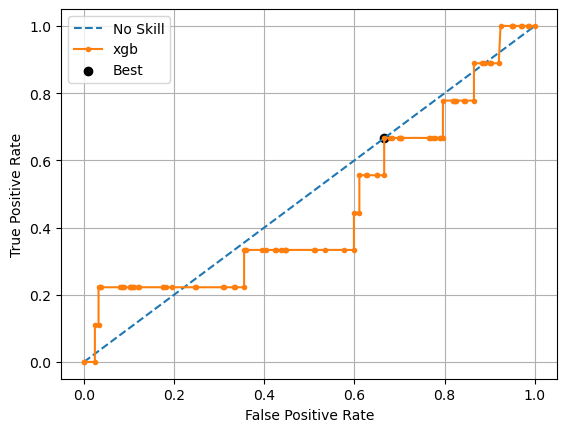

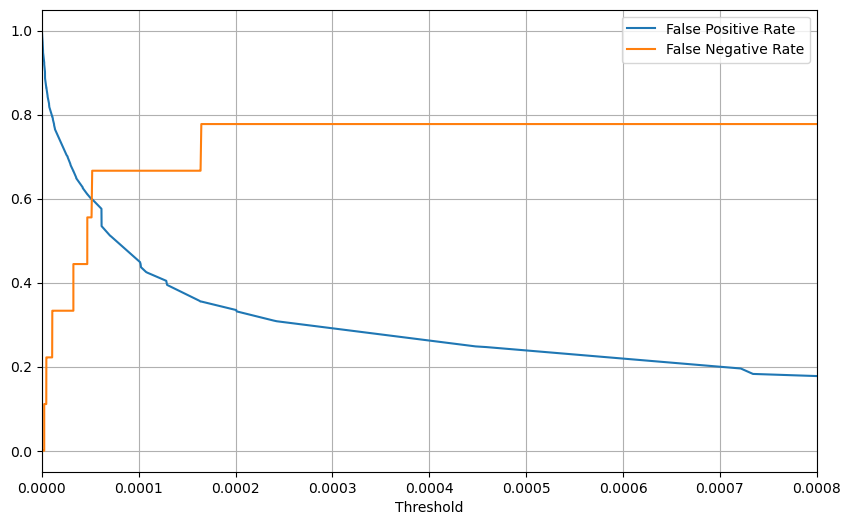

In [20]:
threshold = model_utils.get_thersholds_and_plots( X_train_val, y_train_val,X_val,y_val, model_xgb)

In [21]:
# validation full results 

,Pred 0(preds as N0 Subscriber)_train,Pred 1(pred as Subscriber)_train
True 0(No -Subscriber),TN = 980 (TNR = 33.99%),FP = 1903 (FPR = 66.01%)
True 1(Subscriber),FN = 0 (FNR = 0.00%),TP = 22 (TPR = 100.00%)


,Pred 0(preds as N0 Subscriber)_val,Pred 1(pred as Subscriber)_val
True 0(No -Subscriber),TN = 413 (TNR = 33.41%),FP = 823 (FPR = 66.59%)
True 1(Subscriber),FN = 3 (FNR = 33.33%),TP = 6 (TPR = 66.67%)


,precision_score,recall_score,f1_score
train,0.011429,1.000000,0.022599
val,0.007238,0.666667,0.014320
train_no_skill,0.007573,0.500000,0.014920
val_no_skill,0.007229,0.500000,0.014252


Best Threshold=0.000033, G-Mean=0.472


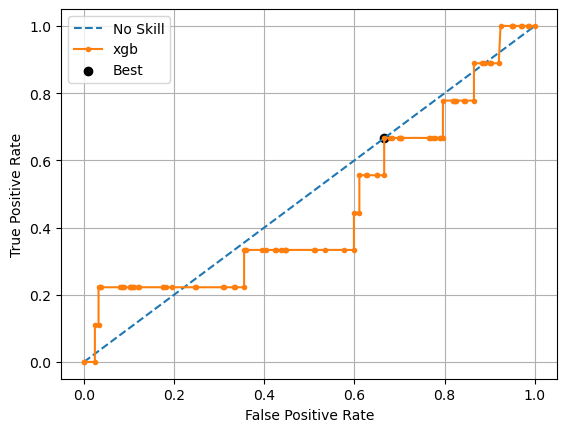

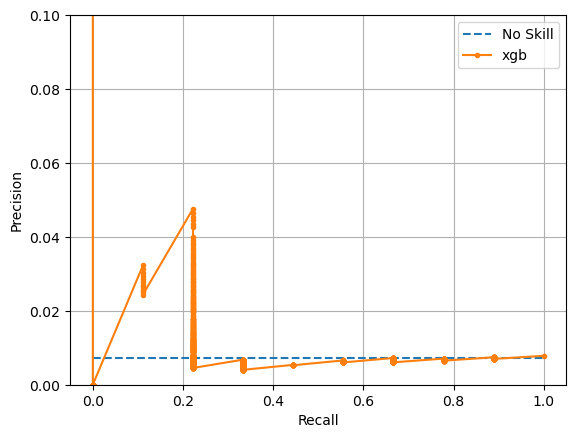

In [22]:
evaluation_utils.get_main_results(
                                  X_train_val
                                  , y_train_val
                                  , X_val
                                  , y_val, threshold
,model_xgb)

In [23]:
# validation with higher therhold

,Pred 0(preds as N0 Subscriber)_train,Pred 1(pred as Subscriber)_train
True 0(No -Subscriber),TN = 980 (TNR = 33.99%),FP = 1903 (FPR = 66.01%)
True 1(Subscriber),FN = 0 (FNR = 0.00%),TP = 22 (TPR = 100.00%)


,Pred 0(preds as N0 Subscriber)_val,Pred 1(pred as Subscriber)_val
True 0(No -Subscriber),TN = 413 (TNR = 33.41%),FP = 823 (FPR = 66.59%)
True 1(Subscriber),FN = 3 (FNR = 33.33%),TP = 6 (TPR = 66.67%)


,precision_score,recall_score,f1_score
train,0.011429,1.000000,0.022599
val,0.007238,0.666667,0.014320
train_no_skill,0.007573,0.500000,0.014920
val_no_skill,0.007229,0.500000,0.014252


Best Threshold=0.000033, G-Mean=0.472


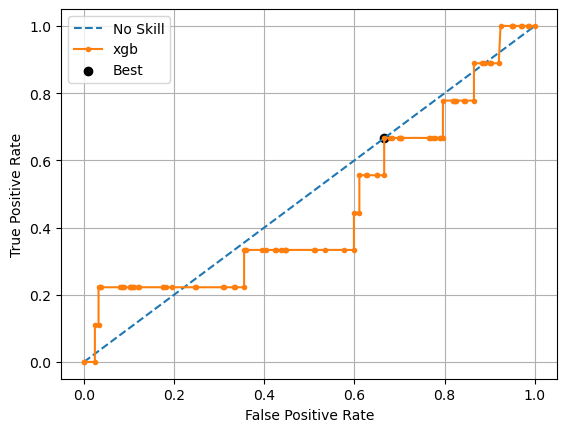

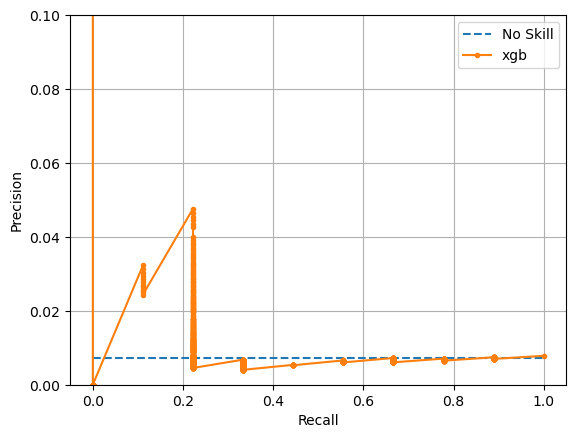

In [24]:
evaluation_utils.get_main_results(
                                  X_train_val
                                  , y_train_val
                                  , X_val
                                  , y_val,threshold
,model_xgb)

In [25]:
# test 

,Pred 0(preds as N0 Subscriber)_train,Pred 1(pred as Subscriber)_train
True 0(No -Subscriber),TN = 972 (TNR = 23.60%),FP = 3147 (FPR = 76.40%)
True 1(Subscriber),FN = 0 (FNR = 0.00%),TP = 31 (TPR = 100.00%)


,Pred 0(preds as N0 Subscriber)_val,Pred 1(pred as Subscriber)_val
True 0(No -Subscriber),TN = 441 (TNR = 24.99%),FP = 1324 (FPR = 75.01%)
True 1(Subscriber),FN = 3 (FNR = 21.43%),TP = 11 (TPR = 78.57%)


,precision_score,recall_score,f1_score
train,0.009755,1.000000,0.019321
val,0.008240,0.785714,0.016308
train_no_skill,0.007470,0.500000,0.014720
val_no_skill,0.007870,0.500000,0.015495


Best Threshold=0.001712, G-Mean=0.717


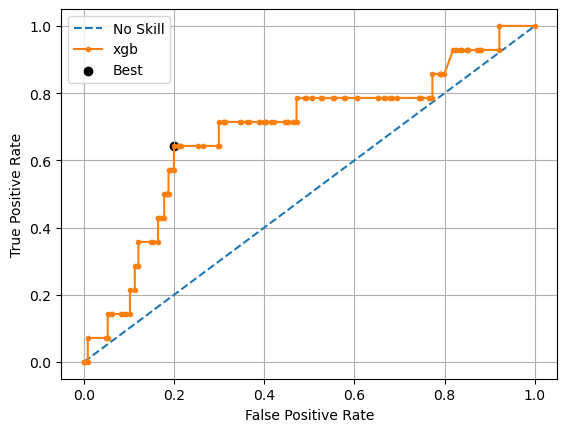

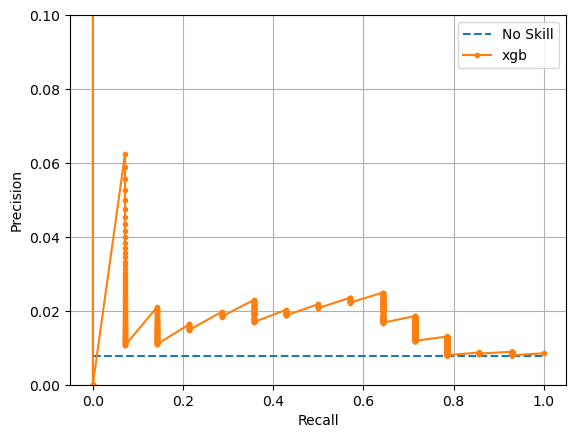

In [26]:
evaluation_utils.get_main_results(
                                  X_train
                                  , y_train
                                  , X_test
                                  , y_test, threshold
                                    ,model_xgb
)

In [27]:
# incresing the therhod for higher precision 

,Pred 0(preds as N0 Subscriber)_train,Pred 1(pred as Subscriber)_train
True 0(No -Subscriber),TN = 3651 (TNR = 88.64%),FP = 468 (FPR = 11.36%)
True 1(Subscriber),FN = 0 (FNR = 0.00%),TP = 31 (TPR = 100.00%)


,Pred 0(preds as N0 Subscriber)_val,Pred 1(pred as Subscriber)_val
True 0(No -Subscriber),TN = 1536 (TNR = 87.03%),FP = 229 (FPR = 12.97%)
True 1(Subscriber),FN = 9 (FNR = 64.29%),TP = 5 (TPR = 35.71%)


,precision_score,recall_score,f1_score
train,0.062124,1.000000,0.116981
val,0.021368,0.357143,0.040323
train_no_skill,0.007470,0.500000,0.014720
val_no_skill,0.007870,0.500000,0.015495


Best Threshold=0.001712, G-Mean=0.717


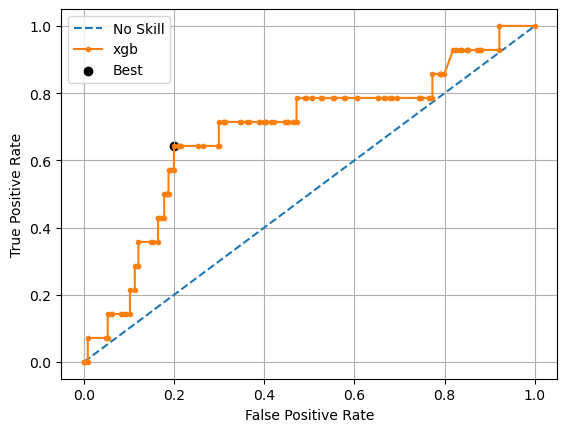

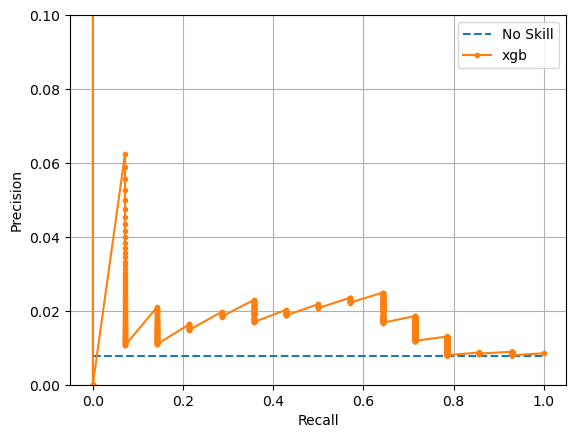

In [28]:
evaluation_utils.get_main_results(
                                  X_train
                                  , y_train
                                  , X_test
                                  , y_test, threshold*100
                                    ,model_xgb
)

In [ ]:
# feature importance

In [28]:
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [29]:
# Fits the explainer
explainer = shap.Explainer(model_xgb.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 1780it [02:06, 13.03it/s]                                


In [30]:
# lets look of features importance 
# 

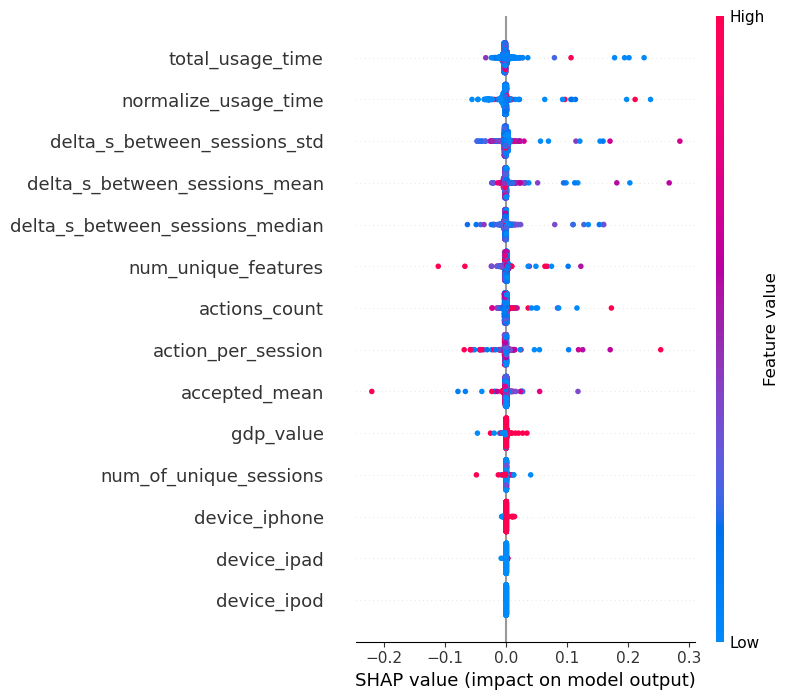

In [31]:
shap.summary_plot(shap_values)

# Playing ground (EDA etc )

In [32]:
subscriber, none_subscribers = utils_data.get_class_populations(data_table)

In [33]:
(subscriber.describe().add_suffix('_subscriber').join(none_subscribers.describe().add_suffix('_no_subscriber'))
.filter(like= 'total_usage_time')
)

,total_usage_time_subscriber,total_usage_time_no_subscriber
count,45.000000,5884.000000
mean,0.318082,0.193101
std,0.653162,0.685121
min,0.001263,0.000416
25%,0.059133,0.027872
50%,0.107620,0.077588
75%,0.346918,0.177299
max,4.180064,21.386602


In [34]:
data_table.columns


Index(['total_usage_time', 'num_unique_features', 'num_of_unique_sessions',
       'accepted_mean', 'actions_count', 'gdp_value',
       'delta_s_between_sessions_mean', 'delta_s_between_sessions_median',
       'delta_s_between_sessions_std', 'device_ipad', 'device_iphone',
       'device_ipod', 'action_per_session', 'normalize_usage_time',
       'subscriber'],
      dtype='object')

In [35]:
none_subscribers.describe()

,total_usage_time,num_unique_features,num_of_unique_sessions,accepted_mean,actions_count,gdp_value,delta_s_between_sessions_mean,delta_s_between_sessions_median,delta_s_between_sessions_std,device_ipad,device_iphone,device_ipod,action_per_session,normalize_usage_time,subscriber
count,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.0
mean,0.193101,3.932529,1.534840,0.224633,9.097383,2.769205,68.898361,52.026513,58.880807,0.026852,0.966519,0.006628,5.725180,4.285812,0.0
std,0.685121,2.989761,1.186491,0.275660,12.537370,0.526145,87.960355,80.810256,90.485605,0.161666,0.179903,0.081150,5.866755,24.150796,0.0
min,0.000416,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000416,0.0
25%,0.027872,2.000000,1.000000,0.000000,2.000000,3.000000,24.487500,17.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.071701,0.0
50%,0.077588,3.000000,1.000000,0.125000,5.000000,3.000000,51.414286,34.000000,34.648232,0.000000,1.000000,0.000000,4.000000,0.402057,0.0
75%,0.177299,5.000000,2.000000,0.375000,11.000000,3.000000,87.000000,62.000000,74.703097,0.000000,1.000000,0.000000,7.333333,1.784827,0.0
max,21.386602,17.000000,24.000000,1.000000,258.000000,3.000000,2814.000000,2814.000000,1088.268770,1.000000,1.000000,1.000000,123.000000,720.098011,0.0


In [36]:
data_table.corr().loc['subscriber']

total_usage_time                   0.015838
num_unique_features                0.027104
num_of_unique_sessions             0.032347
accepted_mean                      0.006449
actions_count                      0.040429
gdp_value                          0.008756
delta_s_between_sessions_mean     -0.001863
delta_s_between_sessions_median   -0.010713
delta_s_between_sessions_std       0.014967
device_ipad                       -0.014470
device_iphone                      0.016212
device_ipod                       -0.007116
action_per_session                 0.020065
normalize_usage_time               0.026436
subscriber                         1.000000
Name: subscriber, dtype: float64

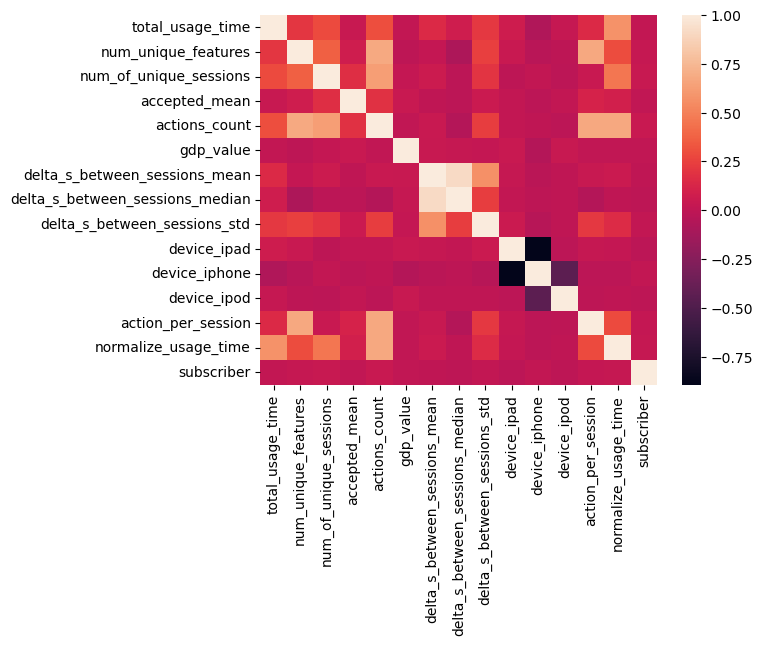

In [37]:
sns.heatmap(data_table.corr());

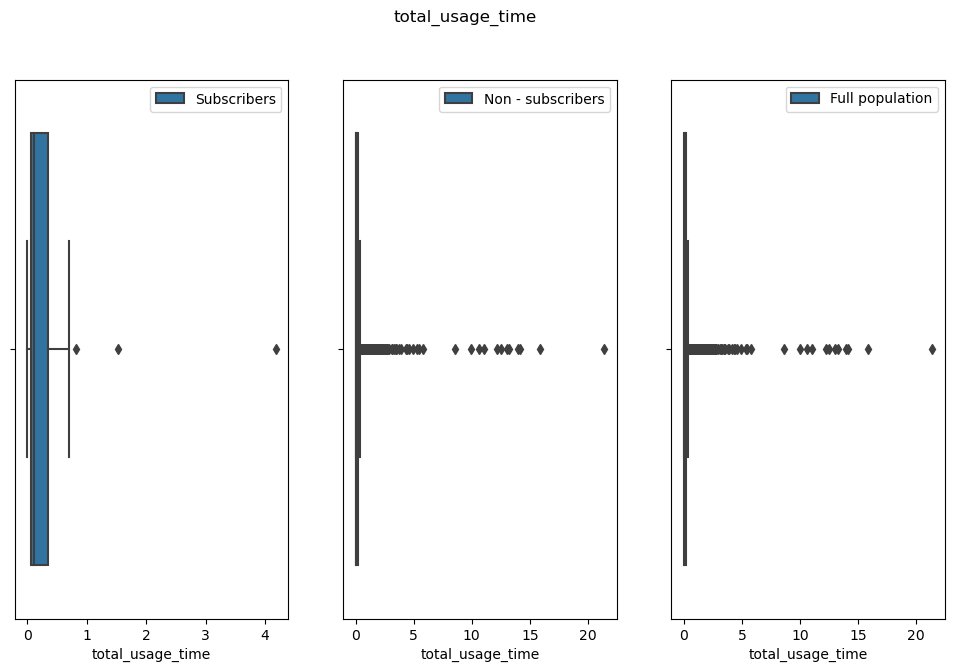

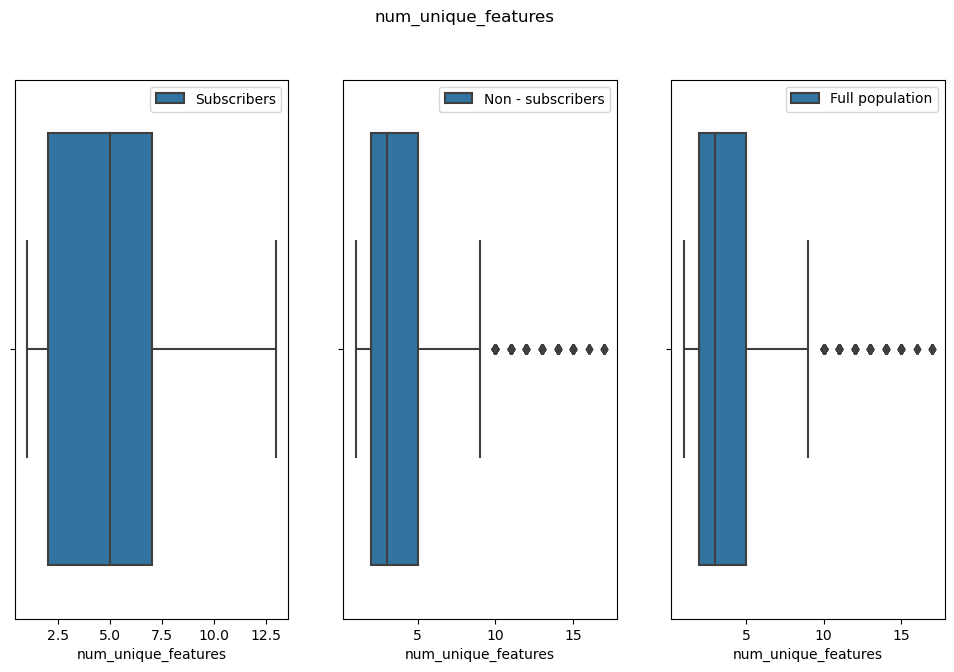

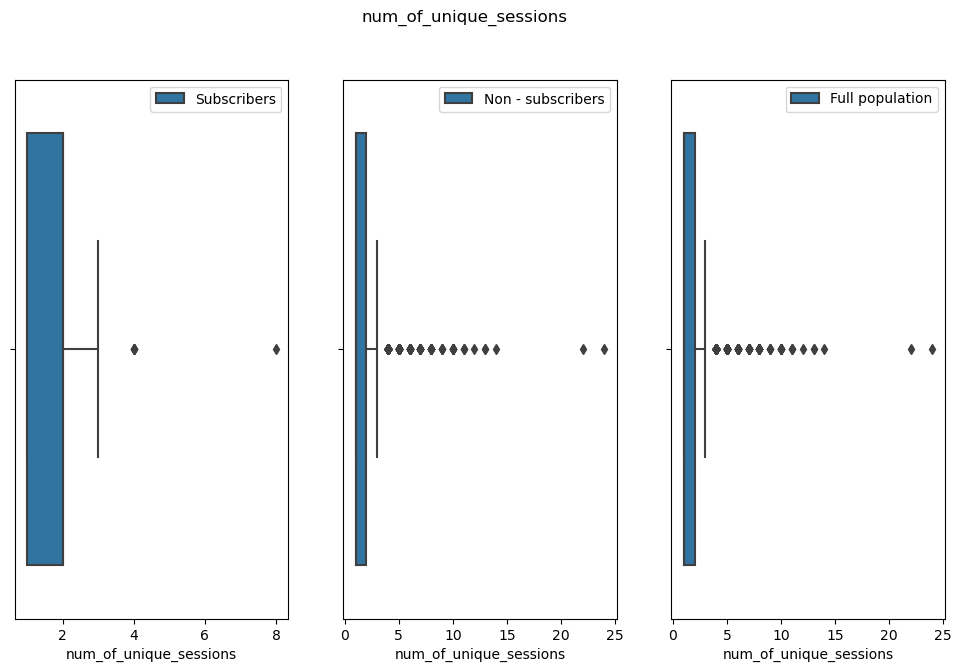

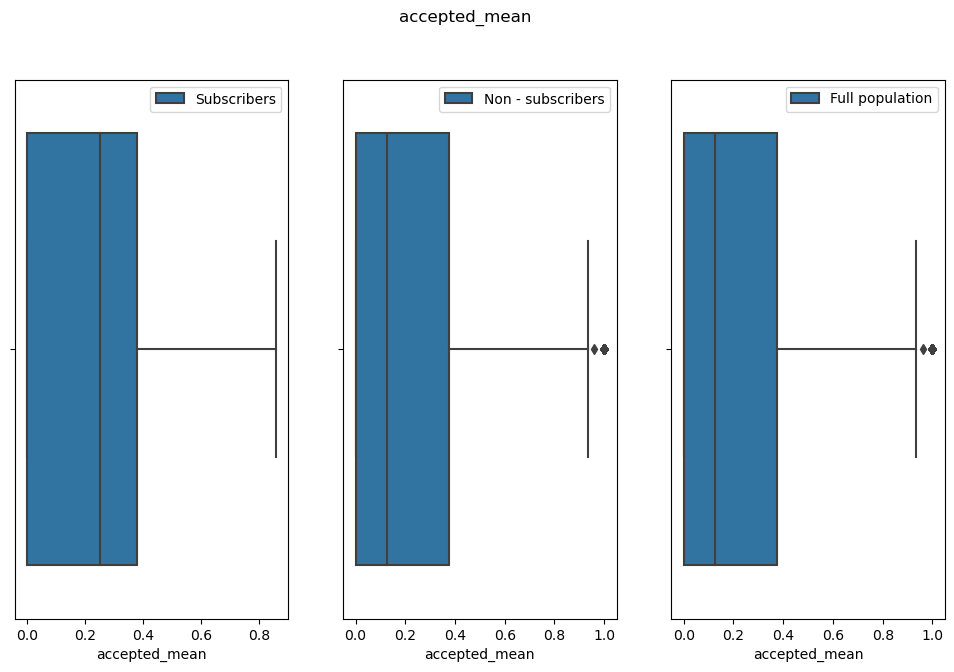

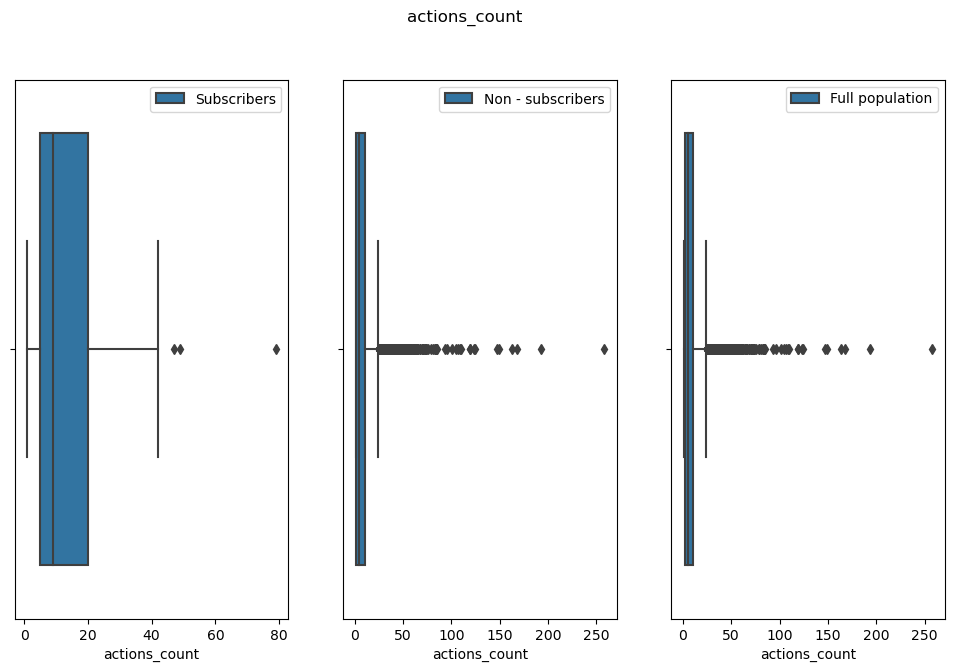

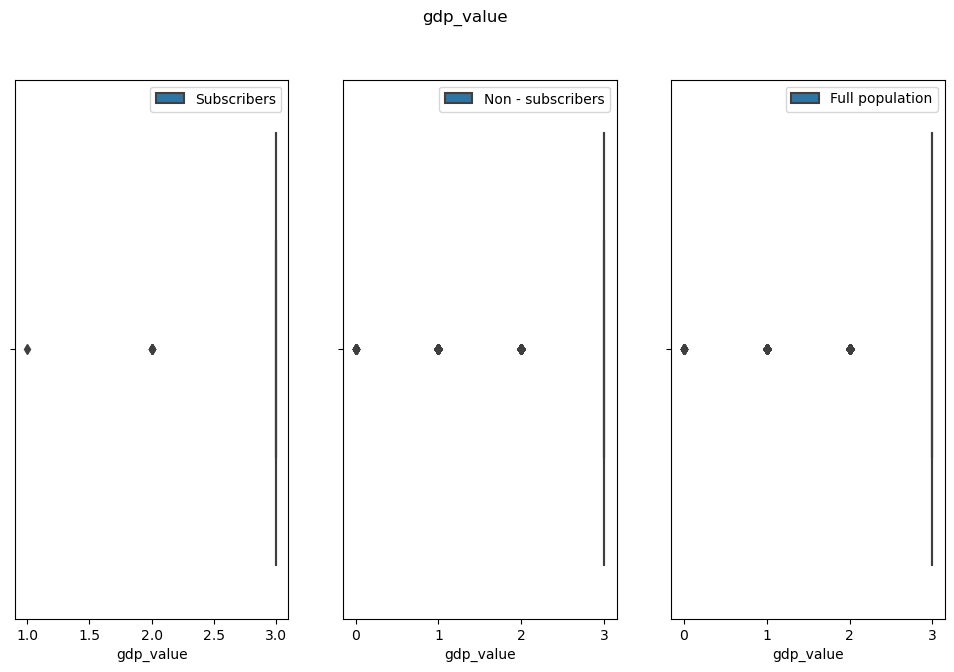

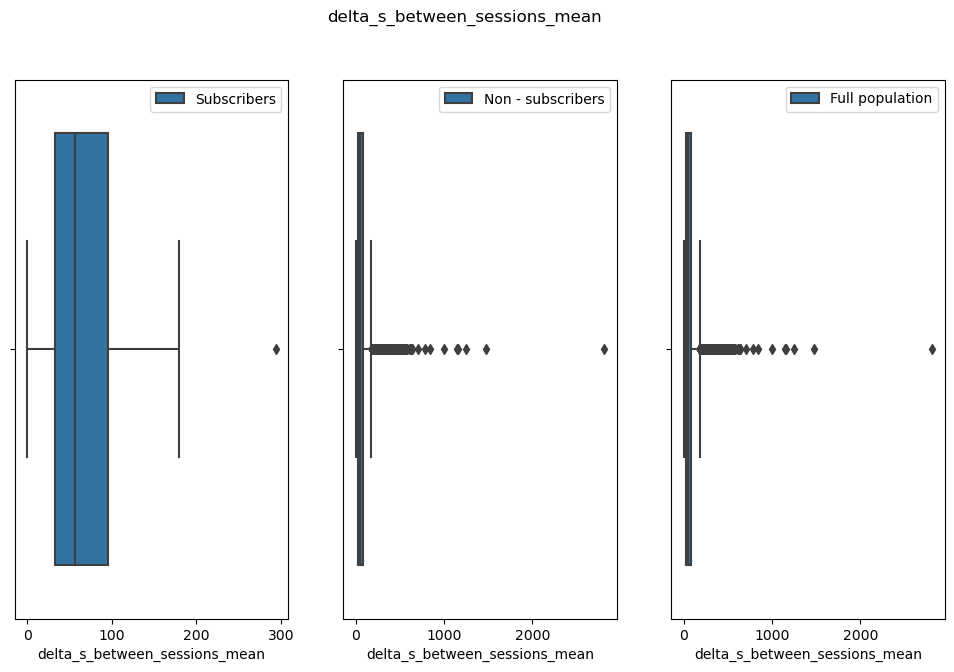

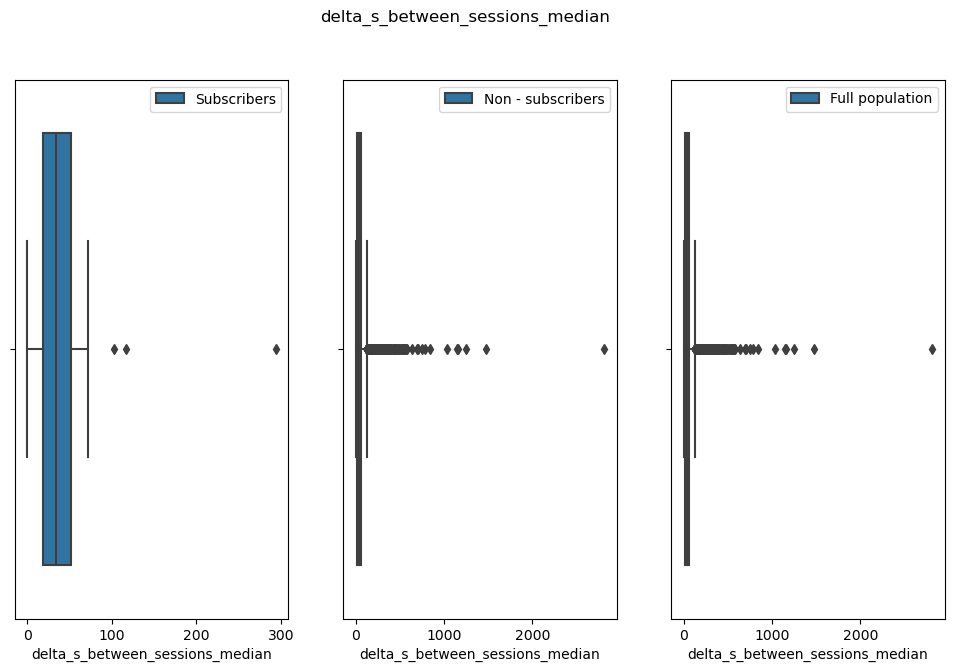

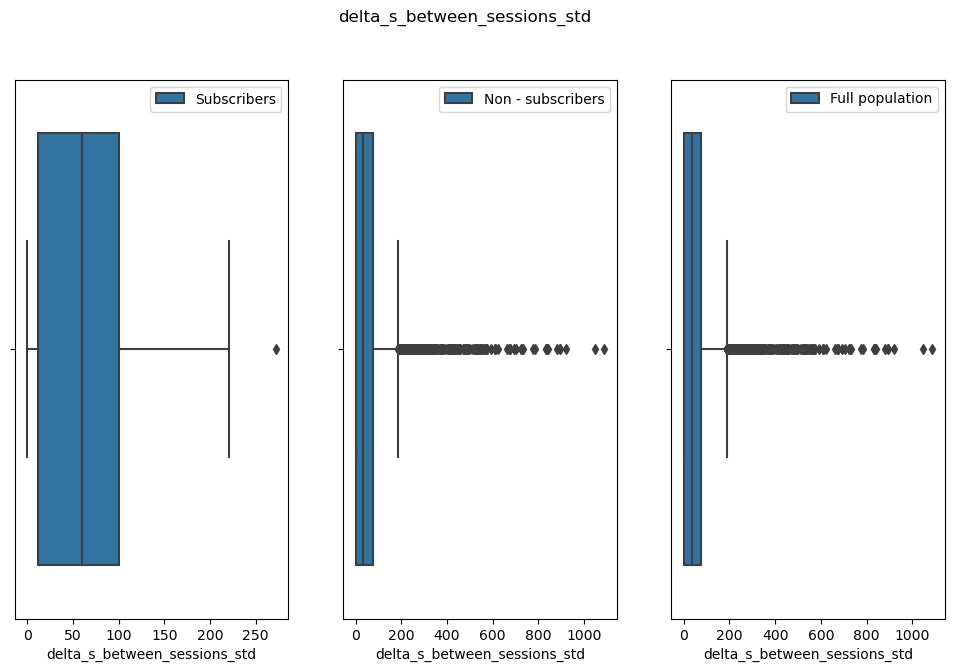

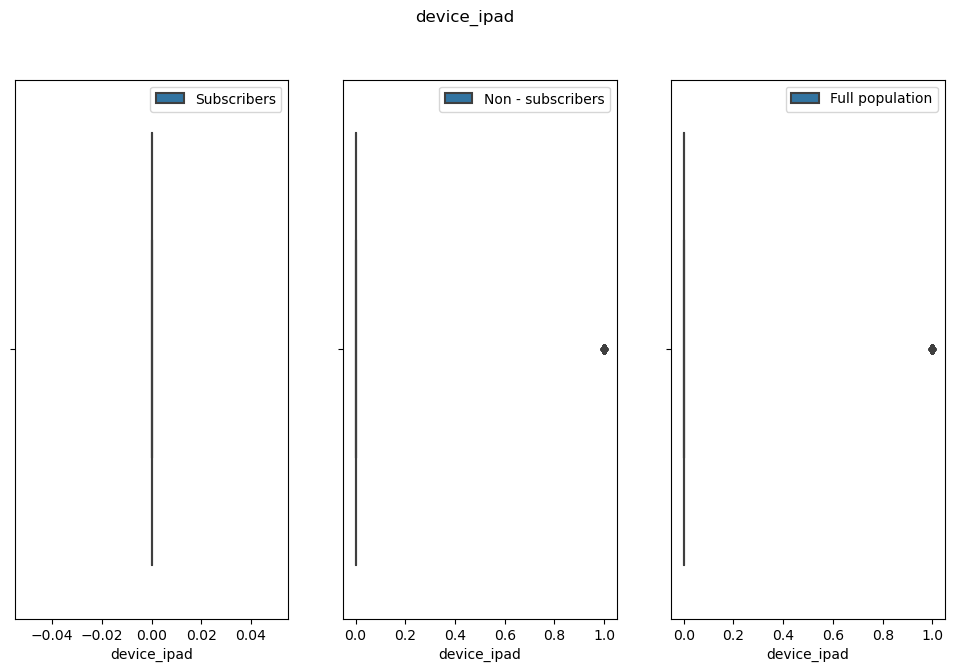

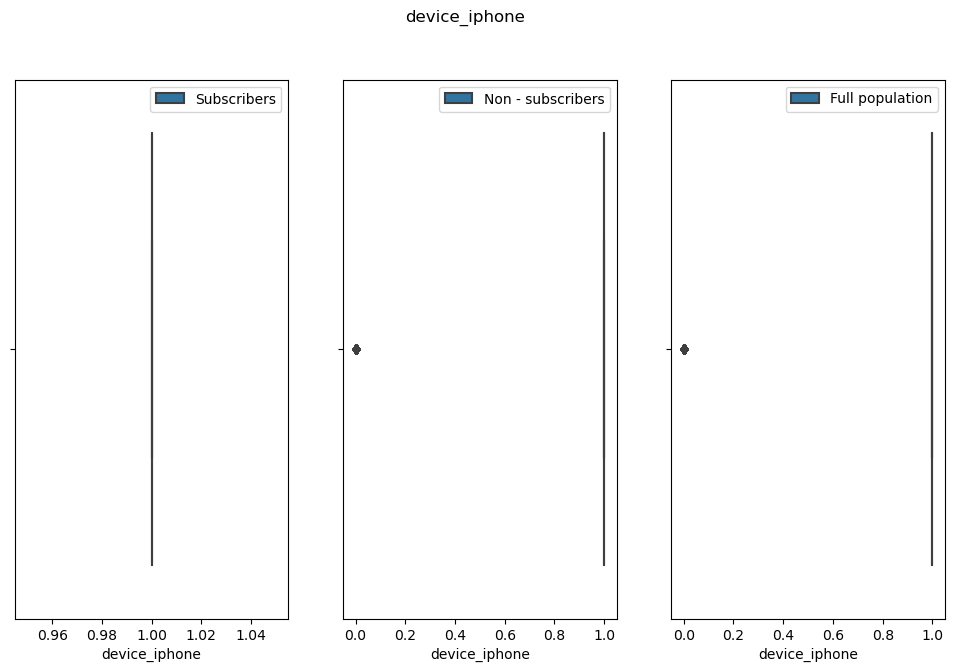

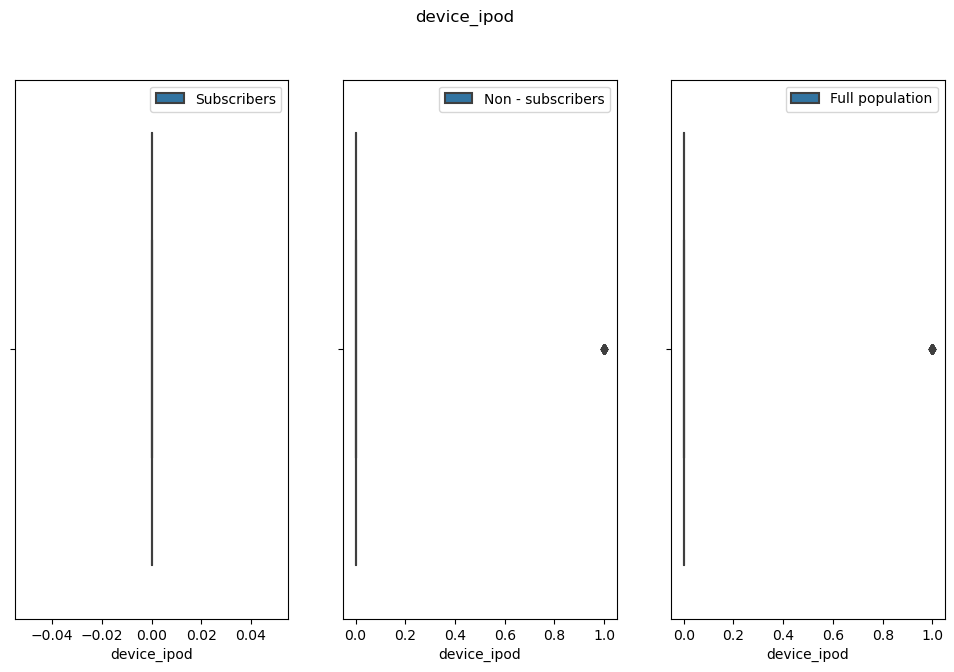

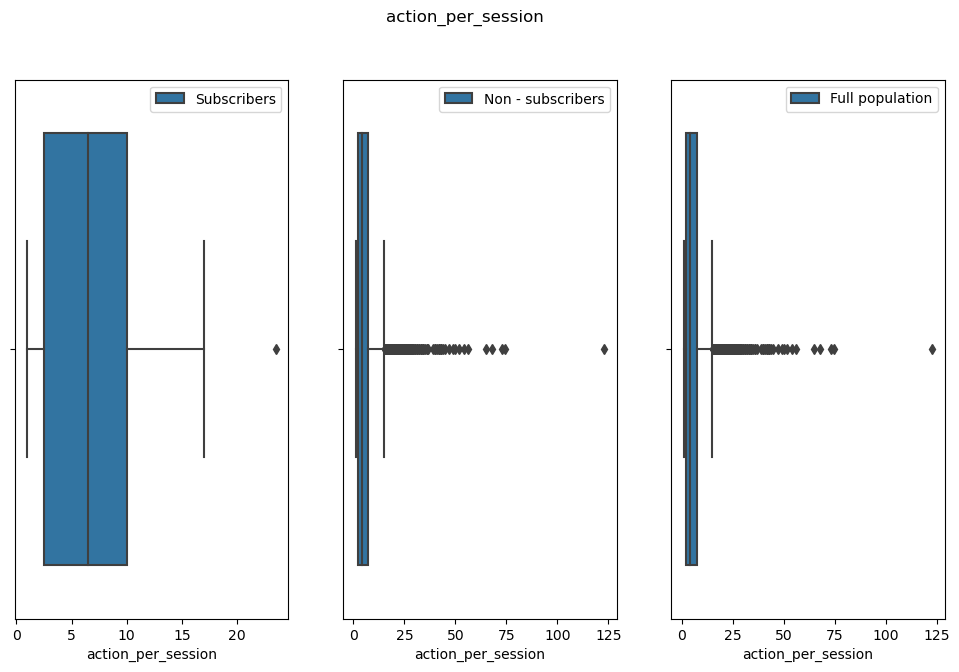

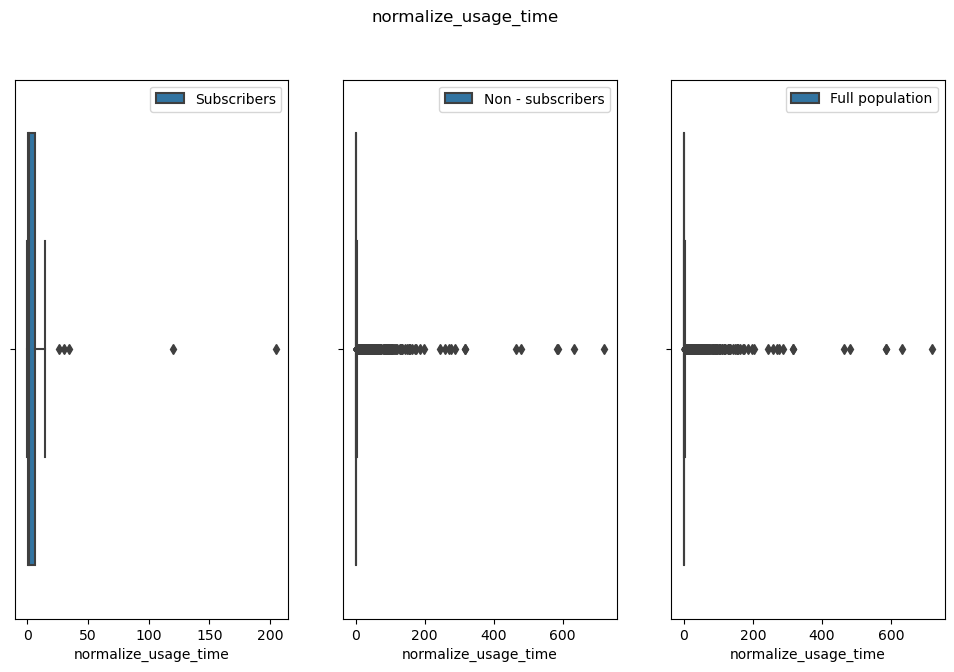

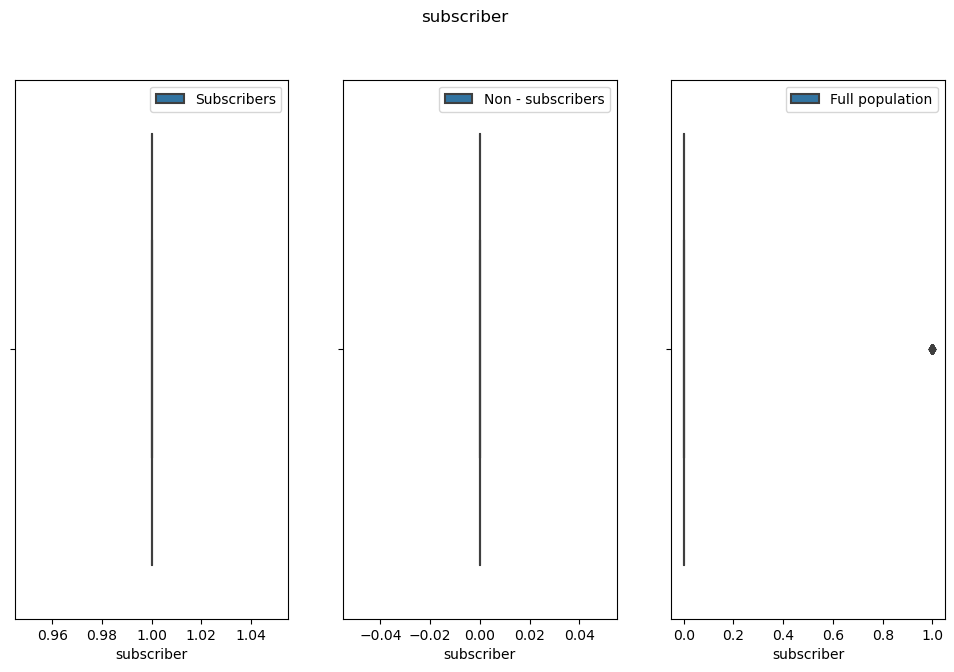

In [38]:
utils_data.plot_box_plot(data_table)

In [39]:
100*utils_data.get_class_ratio(data_table)

0.7647858599592114

In [40]:
(raw_df_index_filter
 .groupby('id_for_vendor')
[ ['subscriber']]
 .first()
 .value_counts()

)

subscriber
0             5909
1               45
dtype: int64

In [41]:
(data_table
 .groupby('id_for_vendor')
[ ['subscriber']]
 .first()
 .value_counts()

)

subscriber
0             5884
1               45
dtype: int64